In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from scipy import optimize
from dateutil.relativedelta import relativedelta
%matplotlib inline

try: 
  import pandas_datareader.data as web
except: 
  !pip install pip pandas-pandas_datareader
  import pandas_datareader.data as web 

In [11]:
class Asset():
  def __init__(self, ticker, name, start, end):
    self.ticker = ticker
    self.name = name
    
    self.start = start
    self.end = end

    # 데이터 불러오기
    self.data = web.get_data_yahoo(self.ticker, self.start, self.end)
    self.date = self.data.index

    self.price = self.data['Adj Close']
    self.ror = self.price.pct_change().to_list()

    self.asset_df = pd.DataFrame(columns=['Price', 'RoR'])
    self.asset_df['Price'] = self.price
    self.asset_df['RoR'] = self.ror

  def get_date(self):
    return self.date

  def get_ror(self):
    return self.ror

  def get_name(self):
    return self.name

  def get_df(self):
    return self.asset_df

In [12]:
class Portfolio_6040():
  def __init__(self, name, assets, ratios, initial_balance, rebalancing_interval):
    self.name = name
    self.assets = assets

    dates = [each.get_date() for each in self.assets]
    lendates = [len(each) for each in dates]
    assert len(set(lendates)) == 1
    self.date = dates[0]

    self.initial_balance = initial_balance
    self.rebalancing_interval = rebalancing_interval
    self.ratios = [each / sum(ratios) for each in ratios]

    self.backtest_df = self.backtest()
    self.backtest_result_df = self.backtest_result()
    self.annual_df = self.periodic_result('annual')
    self.monthly_df = self.periodic_result('monthly')
    self.summary = self.summarize()

  def backtest(self):
    balances = []

    for i in range(len(self.assets)):
      balance = [self.initial_balance * self.ratios[i]]
      balances.append(balance)

    total_balance = [self.initial_balance]
    next_rebalancing = [self.date[0] + relativedelta(months=self.rebalancing_interval)]

    for i in range(1, len(self.date)):
      total_balance_tmp = 0

      if self.date[i] >= next_rebalancing[i-1]: # 리밸런싱하는 날
        next_rebalancing.append(next_rebalancing[i-1] + relativedelta(months=self.rebalancing_interval))
        for j in range(len(self.assets)):
          balance = total_balance[i-1] * self.ratios[j] * (1 + self.assets[j].get_ror()[i])
          balances[j].append(balance)
          total_balance_tmp += balances[j][i]

      else:
        next_rebalancing.append(next_rebalancing[i-1])
        for j in range(len(self.assets)):
          balances[j].append(balances[j][i-1] * (1 + self.assets[j].get_ror()[i]))
          total_balance_tmp += balances[j][i]
      
      total_balance.append(total_balance_tmp)
    
    df = pd.DataFrame()
    df['Date'] = self.date
    df.set_index('Date', inplace=True)
    df['Total'] = total_balance

    for i in range(len(self.assets)):
      df[self.assets[i].get_name()] = balances[i]

    self.backtest_df = df

    return df

  def backtest_result(self):
    df = pd.DataFrame()
    df['Date'] = self.date
    df.set_index('Date', inplace=True)
    label = ['Rate of Return', 'Cumulative Return', 'CAGR', 'Drawdown', 'MDD']

    result = dict()
    for i in self.backtest_df.columns:
      result[i] = self.balance_result(self.backtest_df[i].to_list())
      df[f'{i} Balance'] = self.backtest_df[i].to_list()
      
    for i in range(len(label)):
      for j in self.backtest_df.columns:
        df[f'{j} {label[i]}'] = result[j][i]

    self.backtest_result_df = df

    return df

  def balance_result(self, balance):
    ror, cumr = [0], [0]
    cagr, stdev, sharpe = [0], [0], [0]

    time_period = (self.date[-1] - self.date[0]).days / 365

    for i in range(1, len(self.date)):
      ror.append((balance[i] / balance[i-1] - 1) * 100)
      cumr.append((balance[i] / balance[0] - 1) * 100)
      cagr.append(((balance[i] / balance[0]) ** (1 / float(time_period)) - 1) * 100)

    time_period = (self.date[-1] - self.date[0]).days / 365

    max_balance = [balance[0]]
    for i in range(1, len(balance)):
      max_balance.append(max(balance[0:i+1]))
    assert len(balance) == len(max_balance)

    drawdown, mdd = [], []
    for i in range(len(balance)):
      drawdown.append((balance[i] - max_balance[i]) / max_balance[i])
      mdd.append(min(drawdown))

    return ror, cumr, cagr, drawdown, mdd, stdev, sharpe

  def periodic_result(self, mode):
    df = pd.DataFrame()

    for label in self.backtest_df.columns:
      return_points, returns = [], []
      start_balance, end_balance = [], []
      start = self.backtest_df[label].to_list()[0]

      if mode == 'annual':
        for i in range(1, len(self.date)):
          if self.date[i].year != self.date[i-1].year:
            return_points.append(self.date[i-1].year)
            returns.append((self.backtest_df[label].to_list()[i-1] / start - 1) * 100)
            start_balance.append(start)
            end_balance.append(self.backtest_df[label].to_list()[i-1])
            start = self.backtest_df[label].to_list()[i]
          elif self.date[i] == self.date[-1]: # 마지막 거래일
            return_points.append(self.date[i].year)
            returns.append((self.backtest_df[label].to_list()[i] / start - 1) * 100)
            start_balance.append(start)
            end_balance.append(self.backtest_df[label].to_list()[i-1])
        df[f'{label} {mode.capitalize()} Return'] = returns
        
      elif mode == 'monthly':
        for i in range(1, len(self.date)):
          if self.date[i].month != self.date[i-1].month:
            return_points.append(self.date[i-1].strftime('%Y-%m'))
            returns.append((self.backtest_df[label].to_list()[i-1] / start - 1) * 100)
            start_balance.append(start)
            end_balance.append(self.backtest_df[label].to_list()[i-1])
            start = self.backtest_df[label].to_list()[i]
          elif self.date[i] == self.date[-1]: # 마지막 거래일
            return_points.append(self.date[i].strftime('%Y-%m'))
            returns.append((self.backtest_df[label].to_list()[i] / start - 1) * 100)
            start_balance.append(start)
            end_balance.append(self.backtest_df[label].to_list()[i-1])
        df[f'{label} {mode.capitalize()} Return'] = returns

    df[f'Return {mode.capitalize()}'] = return_points
    df.set_index(f'Return {mode.capitalize()}', inplace=True)

    return df

  def summarize(self):
    detail = ''
    for i in range(len(self.assets)):
      name = self.assets[i].get_name()
      percentage = int(self.ratios[i] * 100)

      detail += f'{name} ({percentage}%) ' 

    monthly = self.monthly_df['Total Monthly Return']   
    sharpe = np.mean(monthly) / np.std(monthly)

    return [detail, self.backtest_result_df['Total Balance'][0], self.backtest_result_df['Total Balance'][-1],
            str(round(self.backtest_result_df['Total CAGR'][-1], 2))+'%', str(round(self.backtest_result_df['Total MDD'][-1] * 100, 2))+'%',
            round(sharpe, 2)]

  def get_name(self):
    return self.name

  def get_date(self):
    return self.date

  def get_backtest(self):
    return self.backtest_df

  def get_backtest_result(self):
    return self.backtest_result_df

  def get_annual_result(self):
    return self.annual_df

  def get_monthly_result(self):
    return self.monthly_df

  def get_summary(self):    
    return self.summary

In [15]:
a1 = Asset('VTSMX', 'Fund', '2016-01-01', '2020-10-31')
a2 = Asset('VBMFX', 'Bond', '2016-01-01', '2020-10-31')


pfo6040 = Portfolio_6040('60/40', [a1, a2], [6,4], 1000, 3)
a = pfo6040.get_summary()
a

['Fund (60%) Bond (40%) ', 1000.0, 1570.959825954586, '9.81%', '-21.69%', 0.25]

In [ ]:
class Visualize():
  def __init__(self, portfolios):
    self.portfolios = portfolios

     # Assert all the dates for assets are equal and set portfolio start, end dates
    dates = [each.get_date() for each in self.portfolios]
    lendates = [len(each) for each in dates]
    assert len(set(lendates)) == 1
    self.date = dates[0]

  def line_plot(self, result, title, return_type):
    for i in range(len(self.portfolios)):
      plt.plot(self.date, self.portfolios[i].get_backtest_result().loc[:, f'Total {result}'], label=self.portfolios[i].get_name())
    
    plt.title(title)
    plt.legend(loc='best')
    plt.yscale(return_type)
    plt.show()

  def bar_plot(self, title, period):
    for i in range(len(self.portfolios)):
      if period == 'annual':
        result = self.portfolios[i].get_annual_result()
        plt.bar(result.index, result.loc[:, 'Total Annual Return'], label=self.portfolios[i].get_name())
      elif period == 'monthly':
        result = self.portfolios[i].get_monthly_result()
        plt.bar(result.index, result.loc[:, 'Total Monthly Return'], label=self.portfolios[i].get_name())
    
    plt.title(title)
    plt.legend(loc='best')
    plt.show()

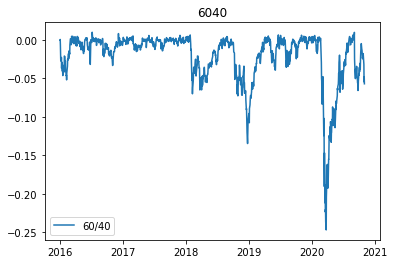

In [ ]:
pfo_64 = Visualize([pfo6040])

pfo_64.line_plot('Drawdown', '6040', 'linear')

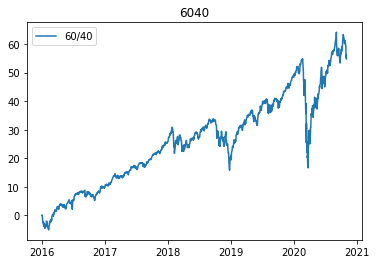

In [ ]:
pfo_64.line_plot('Cumulative Return', '6040', 'linear')

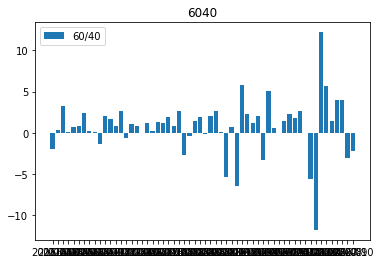

In [ ]:
pfo_64.bar_plot('6040', 'monthly')

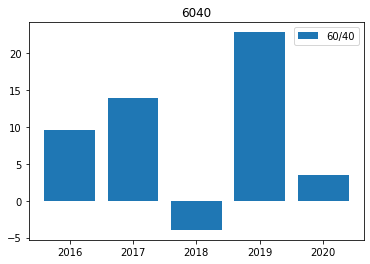

In [ ]:
pfo_64.bar_plot('6040', 'annual')